In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt 
from scipy.spatial import Delaunay 

In [15]:
with open('../../Morphing/Photos/pointsNoShoulders.json') as jsonFile:
    keyPoints = json.load(jsonFile)

In [16]:
im1Points = np.array(keyPoints['im2Points'])
im2Points = np.array(keyPoints['im2Points'])
print(im2Points[0], im2Points[0])

[202 349] [212 441]


In [17]:
np.average([im2Points[0], im2Points[0]], axis=0)

array([207., 395.])

In [53]:
averagePoints = [np.average(a, axis=0) for a in zip(im2Points, im2Points)]
averagePoints = np.array(averagePoints)
print(averagePoints.shape)

(30, 2)


In [57]:
triAverage = Delaunay(averagePoints) 
triIm1 = Delaunay(im2Points)
triIm2 = Delaunay(im2Points)

<Figure size 640x480 with 0 Axes>

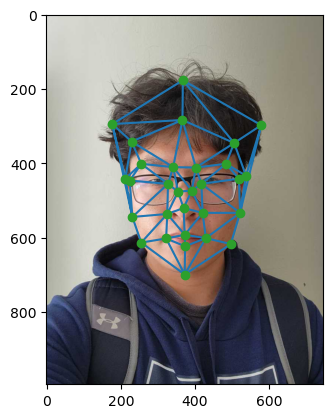

In [58]:
#Average tri on img2 face
fig = plt.figure()
fig, ax = plt.subplots()
img = plt.imread('../../Morphing/Photos/thomasRescaled.jpg')
ax.imshow(img)

plt.triplot(im2Points[:,0], im2Points[:,1], triIm2.simplices)
plt.plot(im2Points[:,0], im2Points[:,1], 'o')
ax.set_aspect('equal', adjustable='box')

<Figure size 640x480 with 0 Axes>

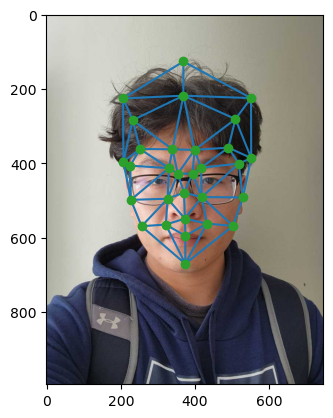

In [56]:
#Average tri on img2 face
fig = plt.figure()
fig, ax = plt.subplots()
img = plt.imread('../../Morphing/Photos/thomasRescaled.jpg')
ax.imshow(img)

plt.triplot(averagePoints[:,0], averagePoints[:,1], triAverage.simplices)
plt.plot(averagePoints[:,0], averagePoints[:,1], 'o')
ax.set_aspect('equal', adjustable='box')


<Figure size 640x480 with 0 Axes>

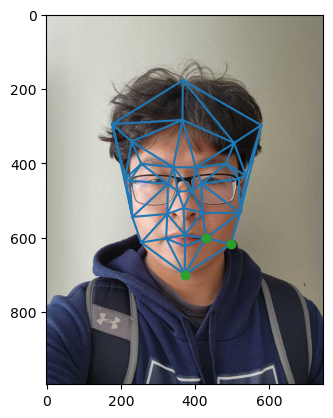

In [73]:
#Select points
fig = plt.figure()
fig, ax = plt.subplots()
img = plt.imread('../../Morphing/Photos/thomasRescaled.jpg')
ax.imshow(img)

plt.triplot(im2Points[:,0], im2Points[:,1], triIm2.simplices)
plt.plot([im2Points[6,0], im2Points[21,0], im2Points[19,0]], [im2Points[6,1], im2Points[21,1], im2Points[19,1]], 'o')
ax.set_aspect('equal', adjustable='box')

In [69]:
triIm2.simplices[3]

array([20,  5, 19], dtype=int32)

In [60]:
averagePoints[1]

array([551. , 385.5])

In [61]:
triangleVector1 = np.array([averagePoints[triAverage.simplices[0][0]] - averagePoints[triAverage.simplices[0][1]],  averagePoints[triAverage.simplices[0][0]] - averagePoints[triAverage.simplices[0][2]]]).T
print(triangleVector1)

[[182.  182. ]
 [  6.5  98.5]]


In [66]:
t1 = np.eye(3)
t1[0:2, 0:2] = triangleVector1
t1[0:2, 2] = averagePoints[triAverage.simplices[0][0]]
t1

array([[182. , 182. , 550.5],
       [  6.5,  98.5, 224. ],
       [  0. ,   0. ,   1. ]])

In [68]:
inverseT1 = np.linalg.inv(t1)
inverseT1.dot(t1)

array([[ 1.00000000e+00,  1.04083409e-17,  5.55111512e-16],
       [-1.04083409e-17,  1.00000000e+00, -4.44089210e-16],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [ ]:
triangleVector = np.array([averagePoints[triAverage.simplices[0][0]] - averagePoints[triAverage.simplices[0][1]],  averagePoints[triAverage.simplices[0][0]] - averagePoints[triAverage.simplices[0][2]]]).T
print(triangleVector)